# Notebook Details
This notebook runs hyperparameter tuning for the Random Forest Classifier Method, and outputs results as a graph.

In [1]:
from rouge_score.rouge_scorer import _create_ngrams
from nltk.stem.porter import PorterStemmer
import json
import six
from utils import tokenize
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

#! N-Gram Score Generation
def get_score_ngrams(target_ngrams, prediction_ngrams):
    intersection_ngrams_count = 0
    ngram_dict = {}
    for ngram in six.iterkeys(target_ngrams):
        intersection_ngrams_count += min(target_ngrams[ngram],
                                        prediction_ngrams[ngram])
        ngram_dict[ngram] = min(target_ngrams[ngram], prediction_ngrams[ngram])
    target_ngrams_count = sum(target_ngrams.values()) # prediction_ngrams
    return intersection_ngrams_count / max(target_ngrams_count, 1), ngram_dict


def get_ngram_info(article_tokens, summary_tokens, _ngram):
    article_ngram = _create_ngrams( article_tokens , _ngram)
    summary_ngram = _create_ngrams( summary_tokens , _ngram)
    ngram_score, ngram_dict = get_score_ngrams( article_ngram, summary_ngram) 
    return ngram_score, ngram_dict, sum( ngram_dict.values() )

print("Loading Data...")
#! Load Data from file
data = None
with open("../regenerated/results_reddit_min100.json", "r") as f:
    data = json.load(f)
print(f"{len(data)} generated texts loaded.")

Loading Data...
2500 generated texts loaded.


In [2]:
#! Calculate n-grams
ngram_overlap_count_wq = []
for idx in tqdm(range(len(data))):
    # tokeniezation
    cur = data[idx]
    masked_original = cur["masked_original"]
    human_tokenized = tokenize(masked_original, stemmer=PorterStemmer())
    generated = cur["masked_generated"]
    if generated == None: continue

    # going through each generation
    temp = []
    for j in range(len(generated)):
        tempp = {} # storing all the ngram scores
        generated_tokenized = tokenize(generated[j], stemmer=PorterStemmer())
        if len(human_tokenized) == 0 or len(generated_tokenized) == 0:
            continue
        
        # go through each possible n gram from 1 to 25
        for _ngram in range(1, 25):
            ngram_score, ngram_dict, overlap_count = get_ngram_info(human_tokenized, generated_tokenized, _ngram)
            if cur["type"] == "human":
                tempp['human_truncate_ngram_{}_score'.format(_ngram)] = ngram_score / len(generated_tokenized)
            else:
                tempp['gpt_truncate_ngram_{}_score'.format(_ngram)] = ngram_score / len(generated_tokenized)
        temp.append({'type':cur["type"], 'ngrams': tempp})

    ngram_overlap_count_wq.append(temp)

  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [04:21<00:00,  9.55it/s]


# Hyper-Parameter Tuning

In [3]:
#! Train an SVM on the data we have gathered
from sklearn.ensemble import RandomForestClassifier

ngram_shuffled = np.random.permutation(ngram_overlap_count_wq)

def test_params(n_estimators=100, test_train_ratio=0.7, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_leaf_nodes=None):
    # Parse Data
    X = []
    Y = []
    for idx in range(len(ngram_shuffled)):
        cur = ngram_shuffled[idx]
        if len(cur) == 0: continue
        if cur[0]['type'] == 'human':
            X.append(list(cur[0]['ngrams'].values()))
            Y.append(0)
        else:
            X.append(list(cur[0]['ngrams'].values()))
            Y.append(1)

    # Split into train and test
    X_train = X[:int(len(X)*test_train_ratio)]
    Y_train = Y[:int(len(Y)*test_train_ratio)]
    X_test = X[int(len(X)*test_train_ratio):]
    Y_test = Y[int(len(Y)*test_train_ratio):]

    # Train SVM
    rfc = RandomForestClassifier(random_state=1, n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, max_leaf_nodes=max_leaf_nodes)
    rfc.fit(X_train, Y_train)

    # Predict Results
    Y_pred = rfc.predict(X_test)

    # Split results into human and ai
    A = []
    B = []
    for idx in range(len(Y_pred)):
        if Y_test[idx] == 0:
            A.append(Y_pred[idx])
        else:
            B.append(Y_pred[idx])
    # Combine scores and true labels
    scores = A + B
    labels = [0] * len(A) + [1] * len(B)
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)

    return roc_auc

def generate_graph(param_name, x, y):
    plt.plot(x, y, color="blue")
    plt.title(f"Hyperparameter Tuning for Random Forest Classifier: {param_name}")
    plt.xlabel(f"{param_name}")
    plt.ylabel("AUROC")
    plt.show()

/home/ajunray/anaconda3/envs/env3/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[0.629182055377677, 0.6181021834502997, 0.6178492183378024, 0.6204656003584876, 0.6271691758396635, 0.6244443801993365, 0.6244805180725503, 0.6258067780195, 0.6191393404115381, 0.6191393404115381]


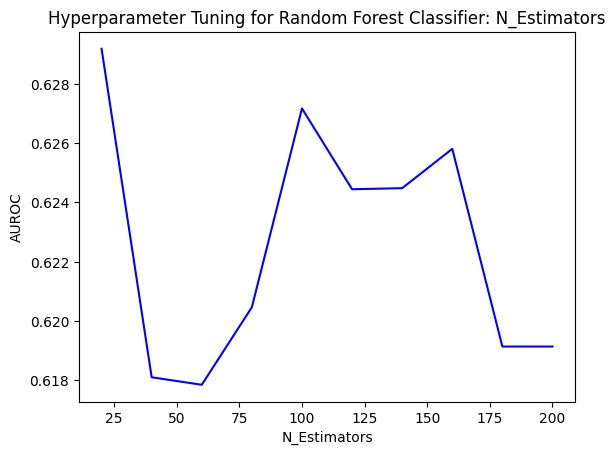

In [4]:
x = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
y = []
for n_estimators in x:
	y.append(test_params(n_estimators=n_estimators))
print(y)
generate_graph("N_Estimators", x, y)

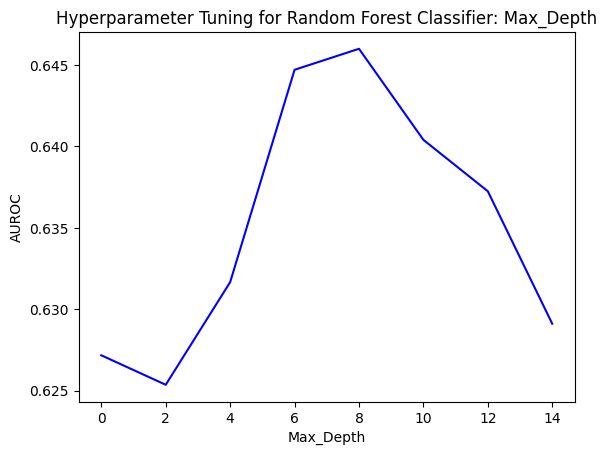

In [5]:
x = [0, 2, 4, 6, 8, 10, 12, 14]
y = []
for max_depth in x:
	y.append(test_params(max_depth=(None if max_depth==0 else max_depth)))
generate_graph("Max_Depth", x, y)

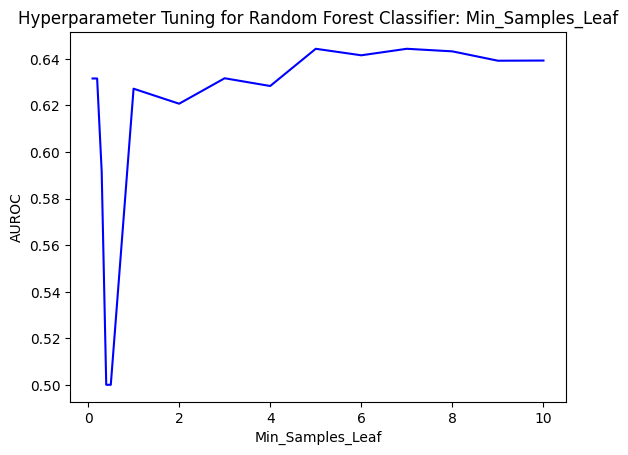

In [6]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = []
for min_samples_leaf in x:
	y.append(test_params(min_samples_leaf=min_samples_leaf))
generate_graph("Min_Samples_Leaf", x, y)

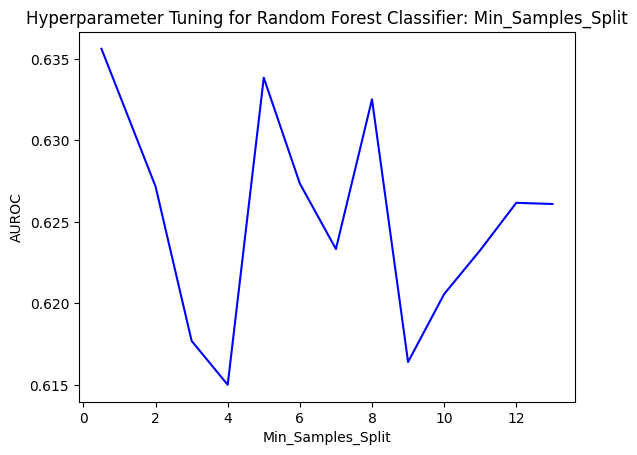

In [7]:
x = [0.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
y = []
for min_samples_split in x:
	y.append(test_params(min_samples_split=min_samples_split))
generate_graph("Min_Samples_Split", x, y)

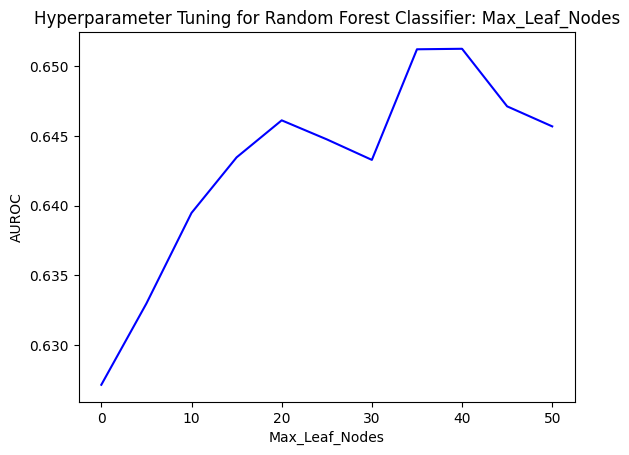

In [8]:
x = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
y = []
for max_leaf_nodes in x:
	y.append(test_params(max_leaf_nodes=(None if max_leaf_nodes==0 else max_leaf_nodes)))
generate_graph("Max_Leaf_Nodes", x, y)

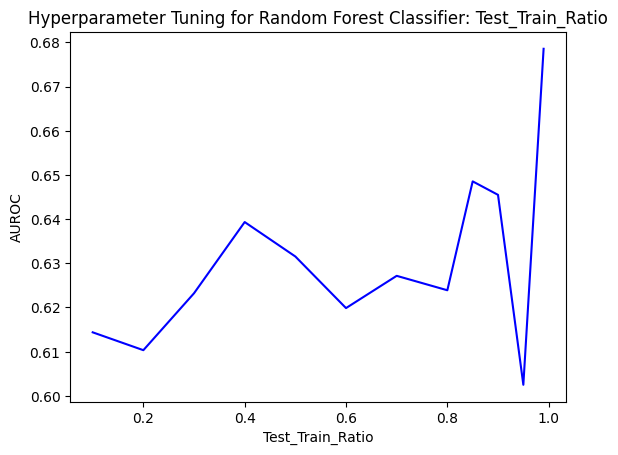

In [9]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
y = []
for test_train_ratio in x:
	y.append(test_params(test_train_ratio=(None if test_train_ratio==0 else test_train_ratio)))
generate_graph("Test_Train_Ratio", x, y)